# NFL Passrush/Blocker Section 2 (of 4)
# Feature Engineering and Metrics

This workbook is where the functions to feature engineer and creatic metrics list, which is then called by an aggregation function which is found in the next workbook.

*A number of features/metrics were created using the motion of the players and the ball, namely how the movements vectors of each compared.*

#### Libraries Used

In [1]:
import nfl_frame_builder as nfl
import nfl_acquire_and_prep as acquire
import pandas as pd
import numpy as np
import itertools
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

from scipy import spatial
import re

#### Generate Random play for testing

In [2]:
# game, play = nfl.random_play()
# game, play

In [3]:
def get_player_type(play_players, nflId):
    '''
    Gets the player type ('pass_rusher' or 'pass_blocker') given an nflId
    
    Parameters:
        'play_players' - Dataframe - A dataframe of play players and their roles and positions
        'nflId' - Integer - The unique id for the primary player being analyzed
    Returns:
        'player_type' - String - The type of player bring analyzed (pass_rusher or pass_blocker)
    '''
    # Get the player type
    player_type = play_players[play_players.nflId == nflId].role.iat[0]

    # Rename from the data to the convention used in these programs
    if player_type == 'Pass Block':
        player_type = 'pass_blocker'

    elif player_type == 'Pass Rush':
        player_type = 'pass_rusher'
    
    else:
        print('Error, Try Again')

    return player_type

In [4]:
def get_random_play_and_player():
    '''
    Generates all the parameters needed to select a random player from a random play, along with his opponents.
    This allows testing of the frame and metrics builders.
    
    Parameters:
        NONE
    Returns:
        'game' - Integer - Game number (unique for season)
        'play' - Integer - Unique for game
        'nflId' - Integer - Unique Id of player being analyzed
        'player_type' - String - The type of player bring analyzed (pass_rusher or pass_blocker)
    '''
    # Pull a random play from a random game
    game, play = nfl.random_play()

    # Get all players in the randomly selected play
    play_players = nfl.get_players_in_play(game, play)

    # Use only players who are blockers or pass rushers
    play_players = play_players[play_players.role.isin(['Pass Rush'])]
    
    # Randomly select a player and get their player type
    nflId = np.random.choice(list(play_players.nflId))
    player_type = get_player_type(play_players, nflId)    

    return game, play, nflId, player_type

In [5]:
game, play, nflId, player_type = get_random_play_and_player()
game, play, nflId, player_type

(2021100700, 3029, 41239, 'pass_rusher')

#### Or enter a specific game-play-player combination

In [6]:
# game = 2021091203
# play = 1521
# nflId = 38559
# player_type = 'pass_rusher'

#### Build frames for analysis 

In [7]:
week_num = nfl.get_week_of_game(game)
week_df = acquire.week(week_num)
scout_pass_block = acquire.scout_pass_block()

In [8]:
qb_hold_time, point_of_scrimmage, analysis_frames = nfl.build_play_frames(game, play, week_df, nflId, scout_pass_block, player_type, v_type = 'PvP')

In [9]:
qb_hold_time, point_of_scrimmage

(2.3, (60.07, 28.22))

In [10]:
analysis_frames.head()

,ball_x,ball_y,ball_next_x,ball_next_y,pass_rusher,pass_rusher_x,pass_rusher_y,pass_rusher_next_x,pass_rusher_next_y,pass_rusher_a,pass_blocker_1,pass_blocker_1_x,pass_blocker_1_y,pass_blocker_1_next_x,pass_blocker_1_next_y,pass_blocker_1_a,pass_blocker_2,pass_blocker_2_x,pass_blocker_2_y,pass_blocker_2_next_x,pass_blocker_2_next_y,pass_blocker_2_a
0,60.26,28.07,60.94,28.06,41239,59.65,25.44,59.69,25.44,0.63,33107,61.42,25.04,61.42,25.05,0.00,52477,61.38,26.76,61.39,26.76,0.36
1,60.94,28.06,61.61,28.05,41239,59.69,25.44,59.76,25.44,1.47,33107,61.42,25.05,61.43,25.05,0.22,52477,61.39,26.76,61.41,26.74,0.83
2,61.61,28.05,62.27,28.04,41239,59.76,25.44,59.86,25.43,1.95,33107,61.43,25.05,61.44,25.05,0.57,52477,61.41,26.74,61.45,26.71,1.43
3,62.27,28.04,62.87,28.05,41239,59.86,25.43,59.99,25.43,2.32,33107,61.44,25.05,61.47,25.06,0.74,52477,61.45,26.71,61.50,26.66,1.93
4,62.87,28.05,63.42,28.07,41239,59.99,25.43,60.18,25.42,2.37,33107,61.47,25.06,61.52,25.07,1.04,52477,61.50,26.66,61.57,26.60,2.06


##### Need to make copy

In [11]:
analysis_frames_tester = analysis_frames.copy()

#### NOTE:  THERE CAN ONLY BE ONE PASS RUSHER PER PLAY.  But multiple pass blockers.

----

## 1. Create vectorizations

Using the snap location, where 'x' = line of scrimmage & 'y' = field location within hash marks, map all x- and y- coordiantes to this location.

First, create a function to take in the snap location and original coordinate and emit the new coordinate

In [12]:
def reorientate_coord(origin, old):
    '''
    This takes in an old x or y coordinate and then remaps their values to an origin coordinate (0,0) which is the
    point_of_scrimmage (line of scrimmage and y location on width of field).
    
    Parameters:
        'origin' - Tuple of Floats - x or y coordinate of snap (point_of_scrimmage)
        'old' - Float - Old x or y coordiante to be reset to new point of scrimmage based origin
    Returns:
        'mod' - Float - New x or y coordinate based on a point of scrimmage origin.
    '''
    # Modified point
    mod = old - origin
    
    return mod

Now use a regex search to modify all the x and y coordiantes.

In [13]:
def recenter_on_snap(point_of_scrimmage, analysis_frames):
    '''
    Applies the reorientate_coord function to all x and y coordinates in dataframe.
    
    Parameters:
        'point_of_scrimmage' - Tuple of Floats - x and y coordinates of snap
        'analysis_frames' - Dataframe - Complete focused frames of the play ready for analysis
    Returns:
        'analysis_frames' - Dataframe - Complete focused frames of the play ready for analysis - now reoriented
    '''

    # Create the x and y regex patters to match
    pattern_x = r'.*[x]$'
    pattern_y = r'.*[y]$'

    # Seperate the point of scrimmage/origin into x and y coordinates
    origin_x = point_of_scrimmage[0]
    origin_y = point_of_scrimmage[1]

    # Look through analysis frames column names to identify whcih ones need to be reoriented to new x or y
    for col in analysis_frames.columns:
        if re.match(pattern_x, col):
            analysis_frames[col] = reorientate_coord(origin_x, analysis_frames[col])
        if re.match(pattern_y, col):
            analysis_frames[col] = reorientate_coord(origin_y, analysis_frames[col])

    return analysis_frames

In [14]:
analysis_frames = recenter_on_snap(point_of_scrimmage, analysis_frames)

## 2. Create distance measures

Simple Euclidean Distance Between Two Points

In [15]:
def euclidean_distance(x1, y1, x2, y2):
    '''
    Finds the straight line distance between two points in R2 (the football field).
    
    Parameters:
        'x1' - Float - X-coorindate of first point
        'y1' - Float - Y-coorindate of first point
        'x2' - Float - X-coorindate of second point
        'y2' - Float - Y-coorindate of second point
    Returns:
        distance - Float - The distance between the two points, in yards
    '''
    # Use the pythagorean theorem
    distance = ((x2 - x1)**2 + (y2 - y1)**2)**0.5
    
    return distance

### Calculate Movement Vectors

In [16]:
def create_movement_vectors(analysis_frames):
    '''
    Finds the x- and y-components of the movement vector for all players and ball, that is the vector between the
    current frame's location and the next frame's location
    
    Parameters:
        'analysis_frames' - Dataframe - Complete frames of the play
    Returns:
        'analysis_frames' - Dataframe - Complete frames of the play, now with movement vectors added
    '''
    # Look through the columns and find those which match pass rusher or blockers
    for column in analysis_frames.columns:
        # Three regex groups - player_type | connector _#_ | and x or y
        match = re.match(r'(ball|pass_rusher|pass_blocker)(_?\d?_)(x|y)', column)
        if match:
            # Use the groups in the matched regex expression to create new column
            mvmt_type = match.group(1)
            connector = match.group(2)
            coord_type = match.group(3)
            original_coord = f"{mvmt_type}{connector}{coord_type}"
            next_coord = f"{mvmt_type}{connector}next_{coord_type}"
            # Subtract the original coordinate from the next coordinate
            analysis_frames[f'{mvmt_type}{connector}distance_moved_{coord_type}'] = analysis_frames[next_coord] - analysis_frames[original_coord]
            
    return analysis_frames

In [17]:
analysis_frames = create_movement_vectors(analysis_frames)

In [18]:
def create_rusher_to_ball_vector(analysis_frames):
    '''
    Create a vector that represents the distance from the player's CURRENT position to the ball's NEXT position.
    
    Parameters:
        'analysis_frames' - Dataframe - Complete frames of the play
    Returns:
        'analysis_frames' - Dataframe - Complete frames of the play ready for analysis with added vector components
    '''
    # Use vector component subtraction 
    analysis_frames['pass_rusher_to_ball_vector_x'] = analysis_frames.ball_next_x - analysis_frames.pass_rusher_x
    analysis_frames['pass_rusher_to_ball_vector_y'] = analysis_frames.ball_next_y - analysis_frames.pass_rusher_y
    
    return analysis_frames

In [19]:
def create_ball_to_rusher_vector(analysis_frames):
    '''
    Create a vector that represents the distance between the ball's CURRENT position and the player's NEXT position.
    
    Parameters:
        'analysis_frames' - Dataframe - Complete frames of the play ready for analysis
    Returns:
        'analysis_frames' - Dataframe - Complete frames of the play ready for analysis with added vector components
    '''
    # Use vector component subtraction 
    analysis_frames['ball_to_pass_rusher_vector_x'] = analysis_frames.ball_next_x - analysis_frames.pass_rusher_next_x
    analysis_frames['ball_to_pass_rusher_vector_y'] = analysis_frames.ball_next_y - analysis_frames.pass_rusher_next_y
    
    return analysis_frames

In [20]:
analysis_frames = create_ball_to_rusher_vector(analysis_frames)

In [21]:
analysis_frames = create_rusher_to_ball_vector(analysis_frames)

### Now create distances between player and ball, for both now and next

In [22]:
def create_change_in_distance_measurement(analysis_frames):
    '''
    Find the change in distance between the player and the ball (next_xy and xy)
    
    Parameters:
        'analysis_frames' - Dataframe - Complete frames of the play ready for analysis
    Returns:
        'analysis_frames' - Dataframe - Complete frames of the play ready for analysis with analysis with change of distances
    '''   
    change_in_pass_rusher_to_ball_dist_list = []
    
    for i in analysis_frames.index:
        n = round(((analysis_frames.ball_next_x.iloc[i] - analysis_frames.pass_rusher_next_x.iloc[i])**2 +
                   (analysis_frames.ball_next_y.iloc[i] - analysis_frames.pass_rusher_next_y.iloc[i])**2)**.5 - 
                  ((analysis_frames.ball_x.iloc[i] - analysis_frames.pass_rusher_x.iloc[i])**2 +
                   (analysis_frames.ball_y.iloc[i] - analysis_frames.pass_rusher_y.iloc[i])**2)**.5, 4)
        if n > .0001:
            change_in_pass_rusher_to_ball_dist_list.append(n)
        else:
            change_in_pass_rusher_to_ball_dist_list.append(.0001)
    
    analysis_frames['change_in_pass_rusher_to_ball_dist'] = change_in_pass_rusher_to_ball_dist_list
    
    return analysis_frames

In [23]:
def create_change_in_distance_ratio(analysis_frames):
    '''
    Find the change in distance between the player and the ball (next_xy and xy)
    
    Parameters:
        'analysis_frames' - Dataframe - Complete frames of the play ready for analysis
    Returns:
        'analysis_frames' - Dataframe - Complete frames of the play ready for analysis with analysis with change of distances
    '''   
    change_in_pass_rusher_to_ball_dist_ratio_list = []
    
    for i in analysis_frames.index:
        n = round(((analysis_frames.ball_x.iloc[i] - analysis_frames.pass_rusher_x.iloc[i])**2 +
                   (analysis_frames.ball_y.iloc[i] - analysis_frames.pass_rusher_y.iloc[i])**2)**.5 /
                  ((analysis_frames.ball_next_x.iloc[i] - analysis_frames.pass_rusher_next_x.iloc[i])**2 +
                   (analysis_frames.ball_next_y.iloc[i] - analysis_frames.pass_rusher_next_y.iloc[i])**2)**.5, 4)
        
        change_in_pass_rusher_to_ball_dist_ratio_list.append(n)
    
    analysis_frames['pass_rusher_to_ball_dist_ratio'] = change_in_pass_rusher_to_ball_dist_ratio_list
    
    return analysis_frames

In [24]:
analysis_frames = create_change_in_distance_measurement(analysis_frames)

In [25]:
analysis_frames = create_change_in_distance_ratio(analysis_frames)

In [26]:
analysis_frames

,ball_x,ball_y,ball_next_x,ball_next_y,pass_rusher,pass_rusher_x,pass_rusher_y,pass_rusher_next_x,pass_rusher_next_y,pass_rusher_a,pass_blocker_1,pass_blocker_1_x,pass_blocker_1_y,pass_blocker_1_next_x,pass_blocker_1_next_y,pass_blocker_1_a,pass_blocker_2,pass_blocker_2_x,pass_blocker_2_y,pass_blocker_2_next_x,pass_blocker_2_next_y,pass_blocker_2_a,ball_distance_moved_x,ball_distance_moved_y,pass_rusher_distance_moved_x,pass_rusher_distance_moved_y,pass_blocker_1_distance_moved_x,pass_blocker_1_distance_moved_y,pass_blocker_2_distance_moved_x,pass_blocker_2_distance_moved_y,ball_to_pass_rusher_vector_x,ball_to_pass_rusher_vector_y,pass_rusher_to_ball_vector_x,pass_rusher_to_ball_vector_y,change_in_pass_rusher_to_ball_dist,pass_rusher_to_ball_dist_ratio
0,0.19,-0.15,0.87,-0.16,41239,-0.42,-2.78,-0.38,-2.78,0.63,33107,1.35,-3.18,1.35,-3.17,0.00,52477,1.31,-1.46,1.32,-1.46,0.36,0.68,-0.01,0.04,0.00,0.00,0.01,0.01,0.00,1.25,2.62,1.29,2.62,0.2031,0.9300
1,0.87,-0.16,1.54,-0.17,41239,-0.38,-2.78,-0.31,-2.78,1.47,33107,1.35,-3.17,1.36,-3.17,0.22,52477,1.32,-1.46,1.34,-1.48,0.83,0.67,-0.01,0.07,0.00,0.01,0.00,0.02,-0.02,1.85,2.61,1.92,2.61,0.2962,0.9074
2,1.54,-0.17,2.20,-0.18,41239,-0.31,-2.78,-0.21,-2.79,1.95,33107,1.36,-3.17,1.37,-3.17,0.57,52477,1.34,-1.48,1.38,-1.51,1.43,0.66,-0.01,0.10,-0.01,0.01,0.00,0.04,-0.03,2.41,2.61,2.51,2.60,0.3533,0.9005
3,2.20,-0.18,2.80,-0.17,41239,-0.21,-2.79,-0.08,-2.79,2.32,33107,1.37,-3.17,1.40,-3.16,0.74,52477,1.38,-1.51,1.43,-1.56,1.93,0.60,0.01,0.13,0.00,0.03,0.01,0.05,-0.05,2.88,2.62,3.01,2.62,0.3409,0.9124
4,2.80,-0.17,3.35,-0.15,41239,-0.08,-2.79,0.11,-2.80,2.37,33107,1.40,-3.16,1.45,-3.15,1.04,52477,1.43,-1.56,1.50,-1.62,2.06,0.55,0.02,0.19,-0.01,0.05,0.01,0.07,-0.06,3.24,2.65,3.43,2.64,0.2923,0.9302
5,3.35,-0.15,3.83,-0.11,41239,0.11,-2.80,0.31,-2.81,2.25,33107,1.45,-3.15,1.52,-3.14,1.08,52477,1.50,-1.62,1.58,-1.69,1.60,0.48,0.04,0.20,-0.01,0.07,0.01,0.08,-0.07,3.52,2.70,3.72,2.69,0.2506,0.9435
6,3.83,-0.11,4.27,-0.06,41239,0.31,-2.81,0.52,-2.84,1.90,33107,1.52,-3.14,1.60,-3.13,0.94,52477,1.58,-1.69,1.67,-1.78,1.16,0.44,0.05,0.21,-0.03,0.08,0.01,0.09,-0.09,3.75,2.78,3.96,2.75,0.2318,0.9503
7,4.27,-0.06,4.65,-0.01,41239,0.52,-2.84,0.74,-2.87,1.12,33107,1.60,-3.13,1.70,-3.12,0.79,52477,1.67,-1.78,1.77,-1.86,0.70,0.38,0.05,0.22,-0.03,0.10,0.01,0.10,-0.08,3.91,2.86,4.13,2.83,0.1763,0.9636
8,4.65,-0.01,4.99,0.06,41239,0.74,-2.87,0.96,-2.91,0.57,33107,1.70,-3.12,1.80,-3.11,0.65,52477,1.77,-1.86,1.88,-1.95,0.19,0.34,0.07,0.22,-0.04,0.10,0.01,0.11,-0.09,4.03,2.97,4.25,2.93,0.1618,0.9677
9,4.99,0.06,5.31,0.13,41239,0.96,-2.91,1.18,-2.97,0.64,33107,1.80,-3.11,1.91,-3.11,0.52,52477,1.88,-1.95,1.99,-2.03,0.15,0.32,0.07,0.22,-0.06,0.11,0.00,0.11,-0.08,4.13,3.10,4.35,3.04,0.1578,0.9694


### Then player and player, now and next

First get a list of pass_blockers when they are the opponents for use in the functions

In [27]:
def get_pass_blockers(analysis_frames):
    '''
    Since there can be anywhere from 1 to 4 pass_blockers (and possibly more in other datasets), this function 
    gets the prefixes such that metrics creation functions can be applied.
    
    Parameters:
        'analysis_frames' - Dataframe - Complete frames of the play ready for analysis
    Returns:
        'pass_blocker_list' - List of Strings - List of all pass_blocker column names
    '''    
    pass_blocker_list = []
    
    for col in analysis_frames.columns:
        if re.search(r'pass_blocker_?\d?$', col):
            pass_blocker_list.append(col)
            
    return pass_blocker_list

In [28]:
get_pass_blockers(analysis_frames)

['pass_blocker_1', 'pass_blocker_2']

Create the distance metrics for player v player (aka opponent)

In [29]:
def player_opponent_distance(analysis_frames):
    '''
    For each opponent (blocker or rusher) adds the distance between them and the analyzed player to the analysis frame.
    Note: Only for v_type = PvP with opponents
    
    Parameters:
        'analysis_frames' - Dataframe - Complete frames of the play ready for analysis
    Returns:
        'analysis_frames' - Dataframe - Complete frames of the play ready for analysis with added distances
    '''
    # Use internal variables to make this visually easier to follow
    prx1 = analysis_frames.pass_rusher_x
    pry1 = analysis_frames.pass_rusher_y
    
    # Get the pass blocker column names
    pass_blocker_list = get_pass_blockers(analysis_frames)
    
    for pass_blocker in pass_blocker_list:
        
        pbx1 = analysis_frames[f'{pass_blocker}_x']
        pby1 = analysis_frames[f'{pass_blocker}_y']
        
        # Get distance from player to opponent
        analysis_frames['temp'] = round(euclidean_distance(prx1, pry1, pbx1, pby1),4)
        
        # Rename the columns
        analysis_frames = analysis_frames.rename(columns = {'temp':f'pass_rusher_{pass_blocker}_dist'})
        
    return analysis_frames

In [30]:
analysis_frames = player_opponent_distance(analysis_frames)

### Now compare the movement vectors between the ball and pass rusher.
1. How their movements compare (colinearity)
2. How the movement of the player compares to the movement of the ball (pursuit)
3. How the movement of the ball compares to the movement of the player (escape)

Colinearity:

In [31]:
def pass_rusher_to_ball_colinearity_calc(pass_rusher_distance_moved_x,
                                         pass_rusher_distance_moved_y,
                                         ball_distance_moved_x,
                                         ball_distance_moved_y):
    '''
    Compares how directionally aligned the movement of the player and the movement of the ball are.
    
    Parameters:
        'pass_rusher_distance_moved_x' - Float - Pulled from analysis frames
        'pass_rusher_distance_moved_y' - Float - Pulled from analysis frames
        'ball_distance_moved_x' - Float - Pulled from analysis frames
        'ball_distance_moved_y' - Float - Pulled from analysis frames
    Returns:
        'mvmt_colinearity' - Float (-1 to 1) - How aligned the player's movement is with the ball movement
    '''
    # Colinearity goes from -1 to 1, with 1 being perfectly aligned, 0 being orthogonal, and -1 being opposite
    mvmt_colinearity = 1 - spatial.distance.cosine([pass_rusher_distance_moved_x,
                                                    pass_rusher_distance_moved_y], 
                                                   [ball_distance_moved_x,
                                                    ball_distance_moved_y])
                            
    return mvmt_colinearity

In [32]:
def add_pass_rusher_to_ball_colinearity(analysis_frames):
    '''
    Computes how similar (colinear) the movemens are between the player and the ball.
    
    Parameters:
        'analysis_frames' - Dataframe - Complete frames of the play
    Returns:
        'analysis_frames' - Dataframe - Complete frames of the play with colinearity added

    '''
    # initialize the list holding the frame by frame pursuit angle calculation
    colinearity_list = []

    for i in analysis_frames.index:
        # Calculate pursuit angle
        colinearity_list.append(round(pass_rusher_to_ball_colinearity_calc(analysis_frames.pass_rusher_distance_moved_x.iloc[i],
                                                                     analysis_frames.pass_rusher_distance_moved_y.iloc[i],
                                                                     analysis_frames.ball_distance_moved_x.iloc[i],
                                                                     analysis_frames.ball_distance_moved_y.iloc[i]),4))

    analysis_frames['colinearity'] = colinearity_list
    
    return analysis_frames

In [33]:
analysis_frames = add_pass_rusher_to_ball_colinearity(analysis_frames)

Pursuit:

In [34]:
def pursuit_factor_calc(pass_rusher_to_ball_vector_x,
                        pass_rusher_to_ball_vector_y,
                        pass_rusher_distance_moved_x,
                        pass_rusher_distance_moved_y):
    '''
    Determines the pursuit angle (cosine distance) between the x and y components of the vector of the player 
    and their next location, and the player and the ball, using similarity (1 - angular distance)
    
    Parameters:
        'pass_rusher_to_ball_vector_x' - Float - Pulled from analysis_frames
        'pass_rusher_to_ball_vector_y' - Float - Pulled from analysis_frames
        'pass_rusher_distance_moved_x' - Float - Pulled from analysis_frames
        'pass_rusher_distance_moved_y' - Float - Pulled from analysis_frames 
    Returns:
        'pursuit_factor' - Float (-1 to 1) - How much of the player's movement is going towards the ball
    '''
    # Pursuit factor goes from -1 to 1, with 1 being perfectly aligned, 0 being orthogonal, and -1 being opposite
    pursuit_factor = 1 - spatial.distance.cosine([pass_rusher_to_ball_vector_x,
                                                  pass_rusher_to_ball_vector_y], 
                                                 [pass_rusher_distance_moved_x,
                                                  pass_rusher_distance_moved_y])
                            
    return pursuit_factor   

In [35]:
def create_pursuit_factor(analysis_frames):
    '''
    Calculates the 'pursuit factor', which is a ratio (from -1 to 1) based on the angle between the pass rusher's
    movement vector, and the vector from the pass rusher to the ball after it moves.
    A negative value means the player is moving in a direction away from the ball; a zero (0) value means they are 
    moving perpendicular to it; for positive values, the closer to one the more direct the movement -
    a value of one means they move directly towards the ball in that interval.
    
    Parameters:
        'analysis_frames' - Dataframe - Complete frames of the play
    Returns:
        'analysis_frames' - Dataframe - Complete frames of the play with pursuit factor added
    '''
    # initialize the list holding the frame by frame pursuit angle calculation
    pursuit_factor_list = []
    
    # This always compares pass rusher to ball
    for i in analysis_frames.index:
        # Calculate pursuit angle
        pursuit_factor_list.append(round(pursuit_factor_calc(analysis_frames.pass_rusher_to_ball_vector_x.iloc[i],
                                                       analysis_frames.pass_rusher_to_ball_vector_y.iloc[i],
                                                       analysis_frames.pass_rusher_distance_moved_x.iloc[i],
                                                       analysis_frames.pass_rusher_distance_moved_y.iloc[i]),4))

    analysis_frames['pursuit_factor'] = pursuit_factor_list

    return analysis_frames

In [36]:
analysis_frames = create_pursuit_factor(analysis_frames)

In [37]:
analysis_frames

,ball_x,ball_y,ball_next_x,ball_next_y,pass_rusher,pass_rusher_x,pass_rusher_y,pass_rusher_next_x,pass_rusher_next_y,pass_rusher_a,pass_blocker_1,pass_blocker_1_x,pass_blocker_1_y,pass_blocker_1_next_x,pass_blocker_1_next_y,pass_blocker_1_a,pass_blocker_2,pass_blocker_2_x,pass_blocker_2_y,pass_blocker_2_next_x,pass_blocker_2_next_y,pass_blocker_2_a,ball_distance_moved_x,ball_distance_moved_y,pass_rusher_distance_moved_x,pass_rusher_distance_moved_y,pass_blocker_1_distance_moved_x,pass_blocker_1_distance_moved_y,pass_blocker_2_distance_moved_x,pass_blocker_2_distance_moved_y,ball_to_pass_rusher_vector_x,ball_to_pass_rusher_vector_y,pass_rusher_to_ball_vector_x,pass_rusher_to_ball_vector_y,change_in_pass_rusher_to_ball_dist,pass_rusher_to_ball_dist_ratio,pass_rusher_pass_blocker_1_dist,pass_rusher_pass_blocker_2_dist,colinearity,pursuit_factor
0,0.19,-0.15,0.87,-0.16,41239,-0.42,-2.78,-0.38,-2.78,0.63,33107,1.35,-3.18,1.35,-3.17,0.00,52477,1.31,-1.46,1.32,-1.46,0.36,0.68,-0.01,0.04,0.00,0.00,0.01,0.01,0.00,1.25,2.62,1.29,2.62,0.2031,0.9300,1.8146,2.1761,0.9999,0.4417
1,0.87,-0.16,1.54,-0.17,41239,-0.38,-2.78,-0.31,-2.78,1.47,33107,1.35,-3.17,1.36,-3.17,0.22,52477,1.32,-1.46,1.34,-1.48,0.83,0.67,-0.01,0.07,0.00,0.01,0.00,0.02,-0.02,1.85,2.61,1.92,2.61,0.2962,0.9074,1.7734,2.1523,0.9999,0.5926
2,1.54,-0.17,2.20,-0.18,41239,-0.31,-2.78,-0.21,-2.79,1.95,33107,1.36,-3.17,1.37,-3.17,0.57,52477,1.34,-1.48,1.38,-1.51,1.43,0.66,-0.01,0.10,-0.01,0.01,0.00,0.04,-0.03,2.41,2.61,2.51,2.60,0.3533,0.9005,1.7149,2.1006,0.9964,0.6195
3,2.20,-0.18,2.80,-0.17,41239,-0.21,-2.79,-0.08,-2.79,2.32,33107,1.37,-3.17,1.40,-3.16,0.74,52477,1.38,-1.51,1.43,-1.56,1.93,0.60,0.01,0.13,0.00,0.03,0.01,0.05,-0.05,2.88,2.62,3.01,2.62,0.3409,0.9124,1.6251,2.0412,0.9999,0.7543
4,2.80,-0.17,3.35,-0.15,41239,-0.08,-2.79,0.11,-2.80,2.37,33107,1.40,-3.16,1.45,-3.15,1.04,52477,1.43,-1.56,1.50,-1.62,2.06,0.55,0.02,0.19,-0.01,0.05,0.01,0.07,-0.06,3.24,2.65,3.43,2.64,0.2923,0.9302,1.5255,1.9476,0.9960,0.7593
5,3.35,-0.15,3.83,-0.11,41239,0.11,-2.80,0.31,-2.81,2.25,33107,1.45,-3.15,1.52,-3.14,1.08,52477,1.50,-1.62,1.58,-1.69,1.60,0.48,0.04,0.20,-0.01,0.07,0.01,0.08,-0.07,3.52,2.70,3.72,2.69,0.2506,0.9435,1.3850,1.8233,0.9912,0.7801
6,3.83,-0.11,4.27,-0.06,41239,0.31,-2.81,0.52,-2.84,1.90,33107,1.52,-3.14,1.60,-3.13,0.94,52477,1.58,-1.69,1.67,-1.78,1.16,0.44,0.05,0.21,-0.03,0.08,0.01,0.09,-0.09,3.75,2.78,3.96,2.75,0.2318,0.9503,1.2542,1.6933,0.9677,0.7324
7,4.27,-0.06,4.65,-0.01,41239,0.52,-2.84,0.74,-2.87,1.12,33107,1.60,-3.13,1.70,-3.12,0.79,52477,1.67,-1.78,1.77,-1.86,0.70,0.38,0.05,0.22,-0.03,0.10,0.01,0.10,-0.08,3.91,2.86,4.13,2.83,0.1763,0.9636,1.1183,1.5640,0.9647,0.7410
8,4.65,-0.01,4.99,0.06,41239,0.74,-2.87,0.96,-2.91,0.57,33107,1.70,-3.12,1.80,-3.11,0.65,52477,1.77,-1.86,1.88,-1.95,0.19,0.34,0.07,0.22,-0.04,0.10,0.01,0.11,-0.09,4.03,2.97,4.25,2.93,0.1618,0.9677,0.9920,1.4426,0.9276,0.7085
9,4.99,0.06,5.31,0.13,41239,0.96,-2.91,1.18,-2.97,0.64,33107,1.80,-3.11,1.91,-3.11,0.52,52477,1.88,-1.95,1.99,-2.03,0.15,0.32,0.07,0.22,-0.06,0.11,0.00,0.11,-0.08,4.13,3.10,4.35,3.04,0.1578,0.9694,0.8635,1.3297,0.8863,0.6401


In [38]:
def component(v1x, v1y, on_v2x, on_v2y):
    '''
    Finds components of one vector [v1x, v1y] that lie along another vector [on_v2x, on_v2y].
    
    Parameters:
        'v1x' - Float - The x of the first vector.
        'v1y' - Float - The y of the first vector.
        'on_v2x' - Float - The x component of the vector we are finding the component of [v1x,v1y] on.
        'on_v2y' - Float - The y component of the vector we are finding the component of [v1x,v1y] on.
    Returns:
        'component' - Array of Floats - The vector representing the component of [v1x,v1y] on [on_v2x, on_v2y]
    '''
    v1 = [v1x, v1y]
    v2 = [on_v2x, on_v2y]
    
    dot_product = np.dot(v1, v2)
    magnitude = np.linalg.norm(v2)
    unit_vector = v2 / magnitude
    component = dot_product / magnitude * unit_vector
    
    return component

In [39]:
def pass_rusher_to_ball_vectors(analysis_frames):
    '''
    Finds the component of the player's movement vector that is going towards the ball.
    
    Parameters:
        'analysis_frames' - Dataframe - Complete frames of the play
    Returns:
        'analysis_frames' - Dataframe - Complete frames of the play with vector components towards ball added
    '''
    # Create lists to hold series to be added to dataframe
    vec_x = []
    vec_y = []
    
    for i in analysis_frames.index:
        p_p_x = analysis_frames.pass_rusher_distance_moved_x[i]
        p_p_y = analysis_frames.pass_rusher_distance_moved_y[i]

        p_b_x = analysis_frames.pass_rusher_to_ball_vector_x[i]
        p_b_y = analysis_frames.pass_rusher_to_ball_vector_y[i]
    
        # Find the x and y components of the player movement relative to the ball
        components = component(p_p_x, p_p_y, p_b_x, p_b_y)

        vec_x.append(round(components[0],4))
        vec_y.append(round(components[1],4))

    # This rewrites the analysis_frames over
    analysis_frames['pass_rusher_to_ball_vector_x'] = vec_x
    
    analysis_frames['pass_rusher_to_ball_vector_y'] = vec_y

    return analysis_frames

In [40]:
analysis_frames = pass_rusher_to_ball_vectors(analysis_frames)

In [41]:
analysis_frames

,ball_x,ball_y,ball_next_x,ball_next_y,pass_rusher,pass_rusher_x,pass_rusher_y,pass_rusher_next_x,pass_rusher_next_y,pass_rusher_a,pass_blocker_1,pass_blocker_1_x,pass_blocker_1_y,pass_blocker_1_next_x,pass_blocker_1_next_y,pass_blocker_1_a,pass_blocker_2,pass_blocker_2_x,pass_blocker_2_y,pass_blocker_2_next_x,pass_blocker_2_next_y,pass_blocker_2_a,ball_distance_moved_x,ball_distance_moved_y,pass_rusher_distance_moved_x,pass_rusher_distance_moved_y,pass_blocker_1_distance_moved_x,pass_blocker_1_distance_moved_y,pass_blocker_2_distance_moved_x,pass_blocker_2_distance_moved_y,ball_to_pass_rusher_vector_x,ball_to_pass_rusher_vector_y,pass_rusher_to_ball_vector_x,pass_rusher_to_ball_vector_y,change_in_pass_rusher_to_ball_dist,pass_rusher_to_ball_dist_ratio,pass_rusher_pass_blocker_1_dist,pass_rusher_pass_blocker_2_dist,colinearity,pursuit_factor
0,0.19,-0.15,0.87,-0.16,41239,-0.42,-2.78,-0.38,-2.78,0.63,33107,1.35,-3.18,1.35,-3.17,0.00,52477,1.31,-1.46,1.32,-1.46,0.36,0.68,-0.01,0.04,0.00,0.00,0.01,0.01,0.00,1.25,2.62,0.0078,0.0159,0.2031,0.9300,1.8146,2.1761,0.9999,0.4417
1,0.87,-0.16,1.54,-0.17,41239,-0.38,-2.78,-0.31,-2.78,1.47,33107,1.35,-3.17,1.36,-3.17,0.22,52477,1.32,-1.46,1.34,-1.48,0.83,0.67,-0.01,0.07,0.00,0.01,0.00,0.02,-0.02,1.85,2.61,0.0246,0.0334,0.2962,0.9074,1.7734,2.1523,0.9999,0.5926
2,1.54,-0.17,2.20,-0.18,41239,-0.31,-2.78,-0.21,-2.79,1.95,33107,1.36,-3.17,1.37,-3.17,0.57,52477,1.34,-1.48,1.38,-1.51,1.43,0.66,-0.01,0.10,-0.01,0.01,0.00,0.04,-0.03,2.41,2.61,0.0432,0.0448,0.3533,0.9005,1.7149,2.1006,0.9964,0.6195
3,2.20,-0.18,2.80,-0.17,41239,-0.21,-2.79,-0.08,-2.79,2.32,33107,1.37,-3.17,1.40,-3.16,0.74,52477,1.38,-1.51,1.43,-1.56,1.93,0.60,0.01,0.13,0.00,0.03,0.01,0.05,-0.05,2.88,2.62,0.0740,0.0644,0.3409,0.9124,1.6251,2.0412,0.9999,0.7543
4,2.80,-0.17,3.35,-0.15,41239,-0.08,-2.79,0.11,-2.80,2.37,33107,1.40,-3.16,1.45,-3.15,1.04,52477,1.43,-1.56,1.50,-1.62,2.06,0.55,0.02,0.19,-0.01,0.05,0.01,0.07,-0.06,3.24,2.65,0.1145,0.0881,0.2923,0.9302,1.5255,1.9476,0.9960,0.7593
5,3.35,-0.15,3.83,-0.11,41239,0.11,-2.80,0.31,-2.81,2.25,33107,1.45,-3.15,1.52,-3.14,1.08,52477,1.50,-1.62,1.58,-1.69,1.60,0.48,0.04,0.20,-0.01,0.07,0.01,0.08,-0.07,3.52,2.70,0.1266,0.0915,0.2506,0.9435,1.3850,1.8233,0.9912,0.7801
6,3.83,-0.11,4.27,-0.06,41239,0.31,-2.81,0.52,-2.84,1.90,33107,1.52,-3.14,1.60,-3.13,0.94,52477,1.58,-1.69,1.67,-1.78,1.16,0.44,0.05,0.21,-0.03,0.08,0.01,0.09,-0.09,3.75,2.78,0.1276,0.0886,0.2318,0.9503,1.2542,1.6933,0.9677,0.7324
7,4.27,-0.06,4.65,-0.01,41239,0.52,-2.84,0.74,-2.87,1.12,33107,1.60,-3.13,1.70,-3.12,0.79,52477,1.67,-1.78,1.77,-1.86,0.70,0.38,0.05,0.22,-0.03,0.10,0.01,0.10,-0.08,3.91,2.86,0.1357,0.0930,0.1763,0.9636,1.1183,1.5640,0.9647,0.7410
8,4.65,-0.01,4.99,0.06,41239,0.74,-2.87,0.96,-2.91,0.57,33107,1.70,-3.12,1.80,-3.11,0.65,52477,1.77,-1.86,1.88,-1.95,0.19,0.34,0.07,0.22,-0.04,0.10,0.01,0.11,-0.09,4.03,2.97,0.1304,0.0899,0.1618,0.9677,0.9920,1.4426,0.9276,0.7085
9,4.99,0.06,5.31,0.13,41239,0.96,-2.91,1.18,-2.97,0.64,33107,1.80,-3.11,1.91,-3.11,0.52,52477,1.88,-1.95,1.99,-2.03,0.15,0.32,0.07,0.22,-0.06,0.11,0.00,0.11,-0.08,4.13,3.10,0.1196,0.0836,0.1578,0.9694,0.8635,1.3297,0.8863,0.6401


Escape:

In [42]:
def escape_factor_calc(ball_distance_moved_x,
                       ball_distance_moved_y,
                       ball_to_pass_rusher_vector_x,
                       ball_to_pass_rusher_vector_y):
    '''
    Determines the pursuit angle (cosine distance) between the x and y components of the vector of the player 
    and their next location, and the player and the ball, using similarity (1 - angular distance)
    
    Parameters:
        'ball_distance_moved_x' - Float - Pulled from analysis_frames
        'ball_distance_moved_y' - Float - Pulled from analysis_frames
        'ball_to_pass_rusher_vector_x' - Float - Pulled from analysis_frames
        'ball_to_pass_rusher_vector_y' - Float - Pulled from analysis_frames 
    Returns:
        'escape_factor' - Float (-1 to 1) - How much of the ball's movement is going away from player
    '''
    # Pursuit factor goes from -1 to 1, with 1 being perfectly aligned, 0 being orthogonal, and -1 being opposite
    escape_factor = 1 - spatial.distance.cosine([ball_distance_moved_x,
                                                 ball_distance_moved_y], 
                                                [ball_to_pass_rusher_vector_x,
                                                 ball_to_pass_rusher_vector_y])
                            
    return escape_factor

In [43]:
def create_escape_factor(analysis_frames):
    '''
    Similar to the pursuit angle, calculates how the ball is moving in relation to the pass rusher.
    
    Parameters:
        'analysis_frames' - Dataframe - Complete frames of the play
    Returns:
        'analysis_frames' - Dataframe - Complete frames of the play with escape factor added
    '''
    # Need to initialize with a value to account for the shift, this frame will later be dropped
    escape_factor_list = []

    for i in analysis_frames.index:
        # Calculate pursuit angle
        escape_factor_list.append(round(escape_factor_calc(analysis_frames.ball_distance_moved_x.iloc[i],
                                                     analysis_frames.ball_distance_moved_y.iloc[i],
                                                     analysis_frames.ball_to_pass_rusher_vector_x.iloc[i],
                                                     analysis_frames.ball_to_pass_rusher_vector_y.iloc[i]),4))

    analysis_frames['escape_factor'] = escape_factor_list
    
    return analysis_frames

In [44]:
analysis_frames = create_escape_factor(analysis_frames)

In [45]:
def ball_to_pass_rusher_vectors(analysis_frames):
    '''
    Finds the component of the ball's movement vector that is going away from the player.
    
    Parameters:
        'analysis_frames' - Dataframe - Complete frames of the play
    Returns:
        'analysis_frames' - Dataframe - Complete frames of the play with vector components away from player added
    '''
    vec_x = []
    vec_y = []
    
    for i in analysis_frames.index:
        b_b_x = analysis_frames.ball_distance_moved_x[i]
        b_b_y = analysis_frames.ball_distance_moved_y[i]

        b_p_x = analysis_frames.ball_to_pass_rusher_vector_x[i]
        b_p_y = analysis_frames.ball_to_pass_rusher_vector_y[i]

        components = component(b_b_x, b_b_y, b_p_x, b_p_y)

        vec_x.append(round(components[0],4))
        vec_y.append(round(components[1],4))

    # This conveniently rewrites the analysis_frames over
    analysis_frames['ball_to_pass_rusher_vector_x'] = vec_x
    
    analysis_frames['ball_to_pass_rusher_vector_y'] = vec_y

    return analysis_frames

In [46]:
analysis_frames = ball_to_pass_rusher_vectors(analysis_frames)

In [47]:
analysis_frames.head()

,ball_x,ball_y,ball_next_x,ball_next_y,pass_rusher,pass_rusher_x,pass_rusher_y,pass_rusher_next_x,pass_rusher_next_y,pass_rusher_a,pass_blocker_1,pass_blocker_1_x,pass_blocker_1_y,pass_blocker_1_next_x,pass_blocker_1_next_y,pass_blocker_1_a,pass_blocker_2,pass_blocker_2_x,pass_blocker_2_y,pass_blocker_2_next_x,pass_blocker_2_next_y,pass_blocker_2_a,ball_distance_moved_x,ball_distance_moved_y,pass_rusher_distance_moved_x,pass_rusher_distance_moved_y,pass_blocker_1_distance_moved_x,pass_blocker_1_distance_moved_y,pass_blocker_2_distance_moved_x,pass_blocker_2_distance_moved_y,ball_to_pass_rusher_vector_x,ball_to_pass_rusher_vector_y,pass_rusher_to_ball_vector_x,pass_rusher_to_ball_vector_y,change_in_pass_rusher_to_ball_dist,pass_rusher_to_ball_dist_ratio,pass_rusher_pass_blocker_1_dist,pass_rusher_pass_blocker_2_dist,colinearity,pursuit_factor,escape_factor
0,0.19,-0.15,0.87,-0.16,41239,-0.42,-2.78,-0.38,-2.78,0.63,33107,1.35,-3.18,1.35,-3.17,0.00,52477,1.31,-1.46,1.32,-1.46,0.36,0.68,-0.01,0.04,0.00,0.00,0.01,0.01,0.00,0.1222,0.2561,0.0078,0.0159,0.2031,0.9300,1.8146,2.1761,0.9999,0.4417,0.4173
1,0.87,-0.16,1.54,-0.17,41239,-0.38,-2.78,-0.31,-2.78,1.47,33107,1.35,-3.17,1.36,-3.17,0.22,52477,1.32,-1.46,1.34,-1.48,0.83,0.67,-0.01,0.07,0.00,0.01,0.00,0.02,-0.02,0.2193,0.3094,0.0246,0.0334,0.2962,0.9074,1.7734,2.1523,0.9999,0.5926,0.5660
2,1.54,-0.17,2.20,-0.18,41239,-0.31,-2.78,-0.21,-2.79,1.95,33107,1.36,-3.17,1.37,-3.17,0.57,52477,1.34,-1.48,1.38,-1.51,1.43,0.66,-0.01,0.10,-0.01,0.01,0.00,0.04,-0.03,0.2988,0.3236,0.0432,0.0448,0.3533,0.9005,1.7149,2.1006,0.9964,0.6195,0.6672
3,2.20,-0.18,2.80,-0.17,41239,-0.21,-2.79,-0.08,-2.79,2.32,33107,1.37,-3.17,1.40,-3.16,0.74,52477,1.38,-1.51,1.43,-1.56,1.93,0.60,0.01,0.13,0.00,0.03,0.01,0.05,-0.05,0.3333,0.3032,0.0740,0.0644,0.3409,0.9124,1.6251,2.0412,0.9999,0.7543,0.7508
4,2.80,-0.17,3.35,-0.15,41239,-0.08,-2.79,0.11,-2.80,2.37,33107,1.40,-3.16,1.45,-3.15,1.04,52477,1.43,-1.56,1.50,-1.62,2.06,0.55,0.02,0.19,-0.01,0.05,0.01,0.07,-0.06,0.3393,0.2776,0.1145,0.0881,0.2923,0.9302,1.5255,1.9476,0.9960,0.7593,0.7966


In [48]:
players_df = acquire.players()

In [49]:
weight = players_df[players_df.nflId == analysis_frames.pass_rusher.max()].weight.iat[0]

In [50]:
weight

280

In [51]:
def pass_rusher_force(analysis_frames, players_df):
    '''
    Integrates the weight of the pass rusher to find the force they are applying in the direction of the ball 
    during pursuit.
    F = mass * acceleration * pursuit factor
    
    Parameters:
        'analysis_frames' - Dataframe - Complete frames of the play
        'players_df' - Dataframe - Contains player information, including weight
    Returns:
        'analysis_frames' - Dataframe - Compete frames of the play with pass_rusher force added
    '''
    # Get conversion rate from (pounds * yards) / seconds^2 to Newtons 
    force_conversion = 0.414764863 
    
    # Pull mass from players_df    
    mass = players_df[players_df.nflId == analysis_frames.pass_rusher.max()].weight.iat[0]

    # Calculate force = mass * acceleration * pursuit factor
    analysis_frames['pass_rusher_force_to_ball'] = round(mass * force_conversion * analysis_frames['pass_rusher_a'] * analysis_frames.pursuit_factor, 2)
    
    return analysis_frames

In [52]:
analysis_frames = pass_rusher_force(analysis_frames, players_df)

In [53]:
analysis_frames.head()

,ball_x,ball_y,ball_next_x,ball_next_y,pass_rusher,pass_rusher_x,pass_rusher_y,pass_rusher_next_x,pass_rusher_next_y,pass_rusher_a,pass_blocker_1,pass_blocker_1_x,pass_blocker_1_y,pass_blocker_1_next_x,pass_blocker_1_next_y,pass_blocker_1_a,pass_blocker_2,pass_blocker_2_x,pass_blocker_2_y,pass_blocker_2_next_x,pass_blocker_2_next_y,pass_blocker_2_a,ball_distance_moved_x,ball_distance_moved_y,pass_rusher_distance_moved_x,pass_rusher_distance_moved_y,pass_blocker_1_distance_moved_x,pass_blocker_1_distance_moved_y,pass_blocker_2_distance_moved_x,pass_blocker_2_distance_moved_y,ball_to_pass_rusher_vector_x,ball_to_pass_rusher_vector_y,pass_rusher_to_ball_vector_x,pass_rusher_to_ball_vector_y,change_in_pass_rusher_to_ball_dist,pass_rusher_to_ball_dist_ratio,pass_rusher_pass_blocker_1_dist,pass_rusher_pass_blocker_2_dist,colinearity,pursuit_factor,escape_factor,pass_rusher_force_to_ball
0,0.19,-0.15,0.87,-0.16,41239,-0.42,-2.78,-0.38,-2.78,0.63,33107,1.35,-3.18,1.35,-3.17,0.00,52477,1.31,-1.46,1.32,-1.46,0.36,0.68,-0.01,0.04,0.00,0.00,0.01,0.01,0.00,0.1222,0.2561,0.0078,0.0159,0.2031,0.9300,1.8146,2.1761,0.9999,0.4417,0.4173,32.32
1,0.87,-0.16,1.54,-0.17,41239,-0.38,-2.78,-0.31,-2.78,1.47,33107,1.35,-3.17,1.36,-3.17,0.22,52477,1.32,-1.46,1.34,-1.48,0.83,0.67,-0.01,0.07,0.00,0.01,0.00,0.02,-0.02,0.2193,0.3094,0.0246,0.0334,0.2962,0.9074,1.7734,2.1523,0.9999,0.5926,0.5660,101.17
2,1.54,-0.17,2.20,-0.18,41239,-0.31,-2.78,-0.21,-2.79,1.95,33107,1.36,-3.17,1.37,-3.17,0.57,52477,1.34,-1.48,1.38,-1.51,1.43,0.66,-0.01,0.10,-0.01,0.01,0.00,0.04,-0.03,0.2988,0.3236,0.0432,0.0448,0.3533,0.9005,1.7149,2.1006,0.9964,0.6195,0.6672,140.29
3,2.20,-0.18,2.80,-0.17,41239,-0.21,-2.79,-0.08,-2.79,2.32,33107,1.37,-3.17,1.40,-3.16,0.74,52477,1.38,-1.51,1.43,-1.56,1.93,0.60,0.01,0.13,0.00,0.03,0.01,0.05,-0.05,0.3333,0.3032,0.0740,0.0644,0.3409,0.9124,1.6251,2.0412,0.9999,0.7543,0.7508,203.23
4,2.80,-0.17,3.35,-0.15,41239,-0.08,-2.79,0.11,-2.80,2.37,33107,1.40,-3.16,1.45,-3.15,1.04,52477,1.43,-1.56,1.50,-1.62,2.06,0.55,0.02,0.19,-0.01,0.05,0.01,0.07,-0.06,0.3393,0.2776,0.1145,0.0881,0.2923,0.9302,1.5255,1.9476,0.9960,0.7593,0.7966,208.99


## Cool metric...

In [54]:
def create_true_pursuit(analysis_frames):
    '''
    Creates a metric that takes into account both the player's movement towards the ball, as well as the ball's
    movement away from the player, comparing those movements to get a truer pursuit factor.
    
    Parameters:
        'analysis_frames' - Dataframe - Complete frames of the play
    Returns:
        'analysis_frames' - Dataframe - Complete frames of the play with new metric added in
    '''
    true_pursuit_list = []
    
    for i in analysis_frames.index:
        true_pursuit_list.append(round((analysis_frames.pass_rusher_to_ball_vector_x.iloc[i]**2 +
                                        analysis_frames.pass_rusher_to_ball_vector_y.iloc[i]**2)**.5 -
                                       (analysis_frames.ball_to_pass_rusher_vector_x.iloc[i]**2 +
                                        analysis_frames.ball_to_pass_rusher_vector_y.iloc[i]**2)**.5,4))
                                 
    analysis_frames['pursuit_vs_escape'] = true_pursuit_list
    
    return analysis_frames

In [55]:
analysis_frames = create_true_pursuit(analysis_frames)
analysis_frames.head()

,ball_x,ball_y,ball_next_x,ball_next_y,pass_rusher,pass_rusher_x,pass_rusher_y,pass_rusher_next_x,pass_rusher_next_y,pass_rusher_a,pass_blocker_1,pass_blocker_1_x,pass_blocker_1_y,pass_blocker_1_next_x,pass_blocker_1_next_y,pass_blocker_1_a,pass_blocker_2,pass_blocker_2_x,pass_blocker_2_y,pass_blocker_2_next_x,pass_blocker_2_next_y,pass_blocker_2_a,ball_distance_moved_x,ball_distance_moved_y,pass_rusher_distance_moved_x,pass_rusher_distance_moved_y,pass_blocker_1_distance_moved_x,pass_blocker_1_distance_moved_y,pass_blocker_2_distance_moved_x,pass_blocker_2_distance_moved_y,ball_to_pass_rusher_vector_x,ball_to_pass_rusher_vector_y,pass_rusher_to_ball_vector_x,pass_rusher_to_ball_vector_y,change_in_pass_rusher_to_ball_dist,pass_rusher_to_ball_dist_ratio,pass_rusher_pass_blocker_1_dist,pass_rusher_pass_blocker_2_dist,colinearity,pursuit_factor,escape_factor,pass_rusher_force_to_ball,pursuit_vs_escape
0,0.19,-0.15,0.87,-0.16,41239,-0.42,-2.78,-0.38,-2.78,0.63,33107,1.35,-3.18,1.35,-3.17,0.00,52477,1.31,-1.46,1.32,-1.46,0.36,0.68,-0.01,0.04,0.00,0.00,0.01,0.01,0.00,0.1222,0.2561,0.0078,0.0159,0.2031,0.9300,1.8146,2.1761,0.9999,0.4417,0.4173,32.32,-0.2661
1,0.87,-0.16,1.54,-0.17,41239,-0.38,-2.78,-0.31,-2.78,1.47,33107,1.35,-3.17,1.36,-3.17,0.22,52477,1.32,-1.46,1.34,-1.48,0.83,0.67,-0.01,0.07,0.00,0.01,0.00,0.02,-0.02,0.2193,0.3094,0.0246,0.0334,0.2962,0.9074,1.7734,2.1523,0.9999,0.5926,0.5660,101.17,-0.3378
2,1.54,-0.17,2.20,-0.18,41239,-0.31,-2.78,-0.21,-2.79,1.95,33107,1.36,-3.17,1.37,-3.17,0.57,52477,1.34,-1.48,1.38,-1.51,1.43,0.66,-0.01,0.10,-0.01,0.01,0.00,0.04,-0.03,0.2988,0.3236,0.0432,0.0448,0.3533,0.9005,1.7149,2.1006,0.9964,0.6195,0.6672,140.29,-0.3782
3,2.20,-0.18,2.80,-0.17,41239,-0.21,-2.79,-0.08,-2.79,2.32,33107,1.37,-3.17,1.40,-3.16,0.74,52477,1.38,-1.51,1.43,-1.56,1.93,0.60,0.01,0.13,0.00,0.03,0.01,0.05,-0.05,0.3333,0.3032,0.0740,0.0644,0.3409,0.9124,1.6251,2.0412,0.9999,0.7543,0.7508,203.23,-0.3525
4,2.80,-0.17,3.35,-0.15,41239,-0.08,-2.79,0.11,-2.80,2.37,33107,1.40,-3.16,1.45,-3.15,1.04,52477,1.43,-1.56,1.50,-1.62,2.06,0.55,0.02,0.19,-0.01,0.05,0.01,0.07,-0.06,0.3393,0.2776,0.1145,0.0881,0.2923,0.9302,1.5255,1.9476,0.9960,0.7593,0.7966,208.99,-0.2939


In [56]:
def create_pursuit1(analysis_frames):
    '''
    Creates a metric that compares the true pursuit to the change in distance between the pass rusher and the ball
    
    Parameters:
        'analysis_frames' - Dataframe - Complete frames of the play
    Returns:
        'analysis_frames' - Dataframe - Complete frames of the play with new metric added in
    '''
    pursuit_list = []
    
    for i in analysis_frames.index:
        frame_pursuit = round(analysis_frames.pursuit_vs_escape.iloc[i] /
                              analysis_frames.change_in_pass_rusher_to_ball_dist.iloc[i],4)
        
        # In order to account for a few manthematical anamolys that occur when the distance between player and ball 
        # stays constant, we set the pursuit metric to -8 or +6, around 4 std from mean.
        # Also, inverting negative to positive as it makes more sense to have positive numbers
        if frame_pursuit > 8:
            pursuit_list.append(-8)
            
        elif frame_pursuit < -6:
            pursuit_list.append(6)
            
        else:
            pursuit_list.append(frame_pursuit * -1)
        
    analysis_frames['pursuit1'] = pursuit_list
    
    return analysis_frames

In [57]:
def create_pursuit2(analysis_frames):
    '''
    Creates a metric that compares the true pursuit to the change in distance between the pass rusher and the ball
    
    Parameters:
        'analysis_frames' - Dataframe - Complete frames of the play
    Returns:
        'analysis_frames' - Dataframe - Complete frames of the play with new metric added in
    '''
    pursuit_list = []
    
    for i in analysis_frames.index:
        frame_pursuit = round(analysis_frames.pursuit_vs_escape.iloc[i] *
                              analysis_frames.pass_rusher_to_ball_dist_ratio.iloc[i],4)
        
        # In order to account for a few manthematical anamolys that occur when the distance between player and ball 
        # stays constant, we set the pursuit metric to -8 or +6, around 4 std from mean.
        # Also, inverting negative to positive as it makes more sense to have positive numbers
#         if frame_pursuit > 8:
#             pursuit_list.append(-8)
            
#         elif frame_pursuit < -6:
#             pursuit_list.append(6)
            
#         else:
        pursuit_list.append(frame_pursuit)
        
    analysis_frames['pursuit2'] = pursuit_list
    
    return analysis_frames

In [58]:
analysis_frames = create_pursuit1(analysis_frames)

In [59]:
analysis_frames = create_pursuit2(analysis_frames)

In [60]:
analysis_frames

,ball_x,ball_y,ball_next_x,ball_next_y,pass_rusher,pass_rusher_x,pass_rusher_y,pass_rusher_next_x,pass_rusher_next_y,pass_rusher_a,pass_blocker_1,pass_blocker_1_x,pass_blocker_1_y,pass_blocker_1_next_x,pass_blocker_1_next_y,pass_blocker_1_a,pass_blocker_2,pass_blocker_2_x,pass_blocker_2_y,pass_blocker_2_next_x,pass_blocker_2_next_y,pass_blocker_2_a,ball_distance_moved_x,ball_distance_moved_y,pass_rusher_distance_moved_x,pass_rusher_distance_moved_y,pass_blocker_1_distance_moved_x,pass_blocker_1_distance_moved_y,pass_blocker_2_distance_moved_x,pass_blocker_2_distance_moved_y,ball_to_pass_rusher_vector_x,ball_to_pass_rusher_vector_y,pass_rusher_to_ball_vector_x,pass_rusher_to_ball_vector_y,change_in_pass_rusher_to_ball_dist,pass_rusher_to_ball_dist_ratio,pass_rusher_pass_blocker_1_dist,pass_rusher_pass_blocker_2_dist,colinearity,pursuit_factor,escape_factor,pass_rusher_force_to_ball,pursuit_vs_escape,pursuit1,pursuit2
0,0.19,-0.15,0.87,-0.16,41239,-0.42,-2.78,-0.38,-2.78,0.63,33107,1.35,-3.18,1.35,-3.17,0.00,52477,1.31,-1.46,1.32,-1.46,0.36,0.68,-0.01,0.04,0.00,0.00,0.01,0.01,0.00,0.1222,0.2561,0.0078,0.0159,0.2031,0.9300,1.8146,2.1761,0.9999,0.4417,0.4173,32.32,-0.2661,1.3102,-0.2475
1,0.87,-0.16,1.54,-0.17,41239,-0.38,-2.78,-0.31,-2.78,1.47,33107,1.35,-3.17,1.36,-3.17,0.22,52477,1.32,-1.46,1.34,-1.48,0.83,0.67,-0.01,0.07,0.00,0.01,0.00,0.02,-0.02,0.2193,0.3094,0.0246,0.0334,0.2962,0.9074,1.7734,2.1523,0.9999,0.5926,0.5660,101.17,-0.3378,1.1404,-0.3065
2,1.54,-0.17,2.20,-0.18,41239,-0.31,-2.78,-0.21,-2.79,1.95,33107,1.36,-3.17,1.37,-3.17,0.57,52477,1.34,-1.48,1.38,-1.51,1.43,0.66,-0.01,0.10,-0.01,0.01,0.00,0.04,-0.03,0.2988,0.3236,0.0432,0.0448,0.3533,0.9005,1.7149,2.1006,0.9964,0.6195,0.6672,140.29,-0.3782,1.0705,-0.3406
3,2.20,-0.18,2.80,-0.17,41239,-0.21,-2.79,-0.08,-2.79,2.32,33107,1.37,-3.17,1.40,-3.16,0.74,52477,1.38,-1.51,1.43,-1.56,1.93,0.60,0.01,0.13,0.00,0.03,0.01,0.05,-0.05,0.3333,0.3032,0.0740,0.0644,0.3409,0.9124,1.6251,2.0412,0.9999,0.7543,0.7508,203.23,-0.3525,1.0340,-0.3216
4,2.80,-0.17,3.35,-0.15,41239,-0.08,-2.79,0.11,-2.80,2.37,33107,1.40,-3.16,1.45,-3.15,1.04,52477,1.43,-1.56,1.50,-1.62,2.06,0.55,0.02,0.19,-0.01,0.05,0.01,0.07,-0.06,0.3393,0.2776,0.1145,0.0881,0.2923,0.9302,1.5255,1.9476,0.9960,0.7593,0.7966,208.99,-0.2939,1.0055,-0.2734
5,3.35,-0.15,3.83,-0.11,41239,0.11,-2.80,0.31,-2.81,2.25,33107,1.45,-3.15,1.52,-3.14,1.08,52477,1.50,-1.62,1.58,-1.69,1.60,0.48,0.04,0.20,-0.01,0.07,0.01,0.08,-0.07,0.3215,0.2466,0.1266,0.0915,0.2506,0.9435,1.3850,1.8233,0.9912,0.7801,0.8413,203.84,-0.2490,0.9936,-0.2349
6,3.83,-0.11,4.27,-0.06,41239,0.31,-2.81,0.52,-2.84,1.90,33107,1.52,-3.14,1.60,-3.13,0.94,52477,1.58,-1.69,1.67,-1.78,1.16,0.44,0.05,0.21,-0.03,0.08,0.01,0.09,-0.09,0.3079,0.2282,0.1276,0.0886,0.2318,0.9503,1.2542,1.6933,0.9677,0.7324,0.8654,161.61,-0.2279,0.9832,-0.2166
7,4.27,-0.06,4.65,-0.01,41239,0.52,-2.84,0.74,-2.87,1.12,33107,1.60,-3.13,1.70,-3.12,0.79,52477,1.67,-1.78,1.77,-1.86,0.70,0.38,0.05,0.22,-0.03,0.10,0.01,0.10,-0.08,0.2714,0.1985,0.1357,0.0930,0.1763,0.9636,1.1183,1.5640,0.9647,0.7410,0.8772,96.38,-0.1717,0.9739,-0.1655
8,4.65,-0.01,4.99,0.06,41239,0.74,-2.87,0.96,-2.91,0.57,33107,1.70,-3.12,1.80,-3.11,0.65,52477,1.77,-1.86,1.88,-1.95,0.19,0.34,0.07,0.22,-0.04,0.10,0.01,0.11,-0.09,0.2538,0.1870,0.1304,0.0899,0.1618,0.9677,0.9920,1.4426,0.9276,0.7085,0.9081,46.90,-0.1569,0.9697,-0.1518
9,4.99,0.06,5.31,0.13,41239,0.96,-2.91,1.18,-2.97,0.64,33107,1.80,-3.11,1.91,-3.11,0.52,52477,1.88,-1.95,1.99,-2.03,0.15,0.32,0.07,0.22,-0.06,0.11,0.00,0.11,-0.08,0.2383,0.1789,0.1196,0.0836,0.1578,0.9694,0.8635,1.3297,0.8863,0.6401,0.9096,47.58,-0.1521,0.9639,-0.1474


In [61]:
def create_pursuit3(analysis_frames):
    '''
    Throwing a Hail Mary...
    '''
    p3 = []
    
    for i in analysis_frames.index:
        ball_distance = (analysis_frames.ball_distance_moved_x.iloc[i]**2 +
                         analysis_frames.ball_distance_moved_y.iloc[i]**2)**.5
        player_towards_ball_dist = (analysis_frames.pass_rusher_to_ball_vector_x.iloc[i]**2 +
                                     analysis_frames.pass_rusher_to_ball_vector_y.iloc[i]**2)**.5
        
        if ball_distance == 0:
            p3.append(player_towards_ball_dist)
        else:
            p3.append(player_towards_ball_dist/ball_distance)
        
    analysis_frames['pursuit3'] = p3

        
    return analysis_frames

In [62]:
def create_pursuit4(analysis_frames):
    '''
    Throwing ANOTHER Hail Mary...
    '''
    p4 = []
    
    for i in analysis_frames.index:
        ball_distance = (analysis_frames.ball_distance_moved_x.iloc[i]**2 +
                         analysis_frames.ball_distance_moved_y.iloc[i]**2)**.5
        player_towards_ball_dist = analysis_frames.pursuit_vs_escape.iloc[i]
        
        if ball_distance == 0:
            p4.append(player_towards_ball_dist)
        else:
            p4.append(player_towards_ball_dist/ball_distance)
        
  
    analysis_frames['pursuit4'] = p4

        
    return analysis_frames

In [63]:
analysis_frames = create_pursuit3(analysis_frames)

In [64]:
analysis_frames = create_pursuit4(analysis_frames)

In [65]:
analysis_frames.head()

,ball_x,ball_y,ball_next_x,ball_next_y,pass_rusher,pass_rusher_x,pass_rusher_y,pass_rusher_next_x,pass_rusher_next_y,pass_rusher_a,pass_blocker_1,pass_blocker_1_x,pass_blocker_1_y,pass_blocker_1_next_x,pass_blocker_1_next_y,pass_blocker_1_a,pass_blocker_2,pass_blocker_2_x,pass_blocker_2_y,pass_blocker_2_next_x,pass_blocker_2_next_y,pass_blocker_2_a,ball_distance_moved_x,ball_distance_moved_y,pass_rusher_distance_moved_x,pass_rusher_distance_moved_y,pass_blocker_1_distance_moved_x,pass_blocker_1_distance_moved_y,pass_blocker_2_distance_moved_x,pass_blocker_2_distance_moved_y,ball_to_pass_rusher_vector_x,ball_to_pass_rusher_vector_y,pass_rusher_to_ball_vector_x,pass_rusher_to_ball_vector_y,change_in_pass_rusher_to_ball_dist,pass_rusher_to_ball_dist_ratio,pass_rusher_pass_blocker_1_dist,pass_rusher_pass_blocker_2_dist,colinearity,pursuit_factor,escape_factor,pass_rusher_force_to_ball,pursuit_vs_escape,pursuit1,pursuit2,pursuit3,pursuit4
0,0.19,-0.15,0.87,-0.16,41239,-0.42,-2.78,-0.38,-2.78,0.63,33107,1.35,-3.18,1.35,-3.17,0.00,52477,1.31,-1.46,1.32,-1.46,0.36,0.68,-0.01,0.04,0.00,0.00,0.01,0.01,0.00,0.1222,0.2561,0.0078,0.0159,0.2031,0.9300,1.8146,2.1761,0.9999,0.4417,0.4173,32.32,-0.2661,1.3102,-0.2475,0.026042,-0.391281
1,0.87,-0.16,1.54,-0.17,41239,-0.38,-2.78,-0.31,-2.78,1.47,33107,1.35,-3.17,1.36,-3.17,0.22,52477,1.32,-1.46,1.34,-1.48,0.83,0.67,-0.01,0.07,0.00,0.01,0.00,0.02,-0.02,0.2193,0.3094,0.0246,0.0334,0.2962,0.9074,1.7734,2.1523,0.9999,0.5926,0.5660,101.17,-0.3378,1.1404,-0.3065,0.061906,-0.504123
2,1.54,-0.17,2.20,-0.18,41239,-0.31,-2.78,-0.21,-2.79,1.95,33107,1.36,-3.17,1.37,-3.17,0.57,52477,1.34,-1.48,1.38,-1.51,1.43,0.66,-0.01,0.10,-0.01,0.01,0.00,0.04,-0.03,0.2988,0.3236,0.0432,0.0448,0.3533,0.9005,1.7149,2.1006,0.9964,0.6195,0.6672,140.29,-0.3782,1.0705,-0.3406,0.094286,-0.572965
3,2.20,-0.18,2.80,-0.17,41239,-0.21,-2.79,-0.08,-2.79,2.32,33107,1.37,-3.17,1.40,-3.16,0.74,52477,1.38,-1.51,1.43,-1.56,1.93,0.60,0.01,0.13,0.00,0.03,0.01,0.05,-0.05,0.3333,0.3032,0.0740,0.0644,0.3409,0.9124,1.6251,2.0412,0.9999,0.7543,0.7508,203.23,-0.3525,1.0340,-0.3216,0.163475,-0.587418
4,2.80,-0.17,3.35,-0.15,41239,-0.08,-2.79,0.11,-2.80,2.37,33107,1.40,-3.16,1.45,-3.15,1.04,52477,1.43,-1.56,1.50,-1.62,2.06,0.55,0.02,0.19,-0.01,0.05,0.01,0.07,-0.06,0.3393,0.2776,0.1145,0.0881,0.2923,0.9302,1.5255,1.9476,0.9960,0.7593,0.7966,208.99,-0.2939,1.0055,-0.2734,0.262501,-0.534011


In [66]:
def build_metrics(analysis_frames, point_of_scrimmage, players_df):
    '''
    Combines all functions to take a given playframe and return frame by frame metrics 
    
    Parameters:
        'analysis_frames' - Dataframe - Complete frames of the play
        'point_of_scrimmage' - Tuple of Floats - x and y coordinates of snap
        'players_df' - Dataframe - Contains player information, including weight
    Returns:
        'analysis_frames' - Dataframe - Complete frames of the play with all metric stuff added
    '''
    analysis_frames = recenter_on_snap(point_of_scrimmage, analysis_frames)
    analysis_frames = create_movement_vectors(analysis_frames)
    analysis_frames = create_rusher_to_ball_vector(analysis_frames)
    analysis_frames = create_ball_to_rusher_vector(analysis_frames)
    analysis_frames = create_change_in_distance_measurement(analysis_frames)
    analysis_frames = create_change_in_distance_ratio(analysis_frames)
    analysis_frames = player_opponent_distance(analysis_frames)
    analysis_frames = add_pass_rusher_to_ball_colinearity(analysis_frames)
    analysis_frames = create_pursuit_factor(analysis_frames)
    analysis_frames = pass_rusher_to_ball_vectors(analysis_frames)
    analysis_frames = create_escape_factor(analysis_frames)
    analysis_frames = ball_to_pass_rusher_vectors(analysis_frames)
    analysis_frames = pass_rusher_force(analysis_frames, players_df)
    analysis_frames = create_true_pursuit(analysis_frames)
    analysis_frames = create_pursuit1(analysis_frames)
    analysis_frames = create_pursuit2(analysis_frames)
    analysis_frames = create_pursuit3(analysis_frames)
    analysis_frames = create_pursuit4(analysis_frames)
    
    return analysis_frames

In [67]:
analysis_frames = build_metrics(analysis_frames_tester, point_of_scrimmage, players_df)
analysis_frames

,ball_x,ball_y,ball_next_x,ball_next_y,pass_rusher,pass_rusher_x,pass_rusher_y,pass_rusher_next_x,pass_rusher_next_y,pass_rusher_a,pass_blocker_1,pass_blocker_1_x,pass_blocker_1_y,pass_blocker_1_next_x,pass_blocker_1_next_y,pass_blocker_1_a,pass_blocker_2,pass_blocker_2_x,pass_blocker_2_y,pass_blocker_2_next_x,pass_blocker_2_next_y,pass_blocker_2_a,ball_distance_moved_x,ball_distance_moved_y,pass_rusher_distance_moved_x,pass_rusher_distance_moved_y,pass_blocker_1_distance_moved_x,pass_blocker_1_distance_moved_y,pass_blocker_2_distance_moved_x,pass_blocker_2_distance_moved_y,pass_rusher_to_ball_vector_x,pass_rusher_to_ball_vector_y,ball_to_pass_rusher_vector_x,ball_to_pass_rusher_vector_y,change_in_pass_rusher_to_ball_dist,pass_rusher_to_ball_dist_ratio,pass_rusher_pass_blocker_1_dist,pass_rusher_pass_blocker_2_dist,colinearity,pursuit_factor,escape_factor,pass_rusher_force_to_ball,pursuit_vs_escape,pursuit1,pursuit2,pursuit3,pursuit4
0,0.19,-0.15,0.87,-0.16,41239,-0.42,-2.78,-0.38,-2.78,0.63,33107,1.35,-3.18,1.35,-3.17,0.00,52477,1.31,-1.46,1.32,-1.46,0.36,0.68,-0.01,0.04,0.00,0.00,0.01,0.01,0.00,0.0078,0.0159,0.1222,0.2561,0.2031,0.9300,1.8146,2.1761,0.9999,0.4417,0.4173,32.32,-0.2661,1.3102,-0.2475,0.026042,-0.391281
1,0.87,-0.16,1.54,-0.17,41239,-0.38,-2.78,-0.31,-2.78,1.47,33107,1.35,-3.17,1.36,-3.17,0.22,52477,1.32,-1.46,1.34,-1.48,0.83,0.67,-0.01,0.07,0.00,0.01,0.00,0.02,-0.02,0.0246,0.0334,0.2193,0.3094,0.2962,0.9074,1.7734,2.1523,0.9999,0.5926,0.5660,101.17,-0.3378,1.1404,-0.3065,0.061906,-0.504123
2,1.54,-0.17,2.20,-0.18,41239,-0.31,-2.78,-0.21,-2.79,1.95,33107,1.36,-3.17,1.37,-3.17,0.57,52477,1.34,-1.48,1.38,-1.51,1.43,0.66,-0.01,0.10,-0.01,0.01,0.00,0.04,-0.03,0.0432,0.0448,0.2988,0.3236,0.3533,0.9005,1.7149,2.1006,0.9964,0.6195,0.6672,140.29,-0.3782,1.0705,-0.3406,0.094286,-0.572965
3,2.20,-0.18,2.80,-0.17,41239,-0.21,-2.79,-0.08,-2.79,2.32,33107,1.37,-3.17,1.40,-3.16,0.74,52477,1.38,-1.51,1.43,-1.56,1.93,0.60,0.01,0.13,0.00,0.03,0.01,0.05,-0.05,0.0740,0.0644,0.3333,0.3032,0.3409,0.9124,1.6251,2.0412,0.9999,0.7543,0.7508,203.23,-0.3525,1.0340,-0.3216,0.163475,-0.587418
4,2.80,-0.17,3.35,-0.15,41239,-0.08,-2.79,0.11,-2.80,2.37,33107,1.40,-3.16,1.45,-3.15,1.04,52477,1.43,-1.56,1.50,-1.62,2.06,0.55,0.02,0.19,-0.01,0.05,0.01,0.07,-0.06,0.1145,0.0881,0.3393,0.2776,0.2923,0.9302,1.5255,1.9476,0.9960,0.7593,0.7966,208.99,-0.2939,1.0055,-0.2734,0.262501,-0.534011
5,3.35,-0.15,3.83,-0.11,41239,0.11,-2.80,0.31,-2.81,2.25,33107,1.45,-3.15,1.52,-3.14,1.08,52477,1.50,-1.62,1.58,-1.69,1.60,0.48,0.04,0.20,-0.01,0.07,0.01,0.08,-0.07,0.1266,0.0915,0.3215,0.2466,0.2506,0.9435,1.3850,1.8233,0.9912,0.7801,0.8413,203.84,-0.2490,0.9936,-0.2349,0.324302,-0.516958
6,3.83,-0.11,4.27,-0.06,41239,0.31,-2.81,0.52,-2.84,1.90,33107,1.52,-3.14,1.60,-3.13,0.94,52477,1.58,-1.69,1.67,-1.78,1.16,0.44,0.05,0.21,-0.03,0.08,0.01,0.09,-0.09,0.1276,0.0886,0.3079,0.2282,0.2318,0.9503,1.2542,1.6933,0.9677,0.7324,0.8654,161.61,-0.2279,0.9832,-0.2166,0.350797,-0.514642
7,4.27,-0.06,4.65,-0.01,41239,0.52,-2.84,0.74,-2.87,1.12,33107,1.60,-3.13,1.70,-3.12,0.79,52477,1.67,-1.78,1.77,-1.86,0.70,0.38,0.05,0.22,-0.03,0.10,0.01,0.10,-0.08,0.1357,0.0930,0.2714,0.1985,0.1763,0.9636,1.1183,1.5640,0.9647,0.7410,0.8772,96.38,-0.1717,0.9739,-0.1655,0.429221,-0.447981
8,4.65,-0.01,4.99,0.06,41239,0.74,-2.87,0.96,-2.91,0.57,33107,1.70,-3.12,1.80,-3.11,0.65,52477,1.77,-1.86,1.88,-1.95,0.19,0.34,0.07,0.22,-0.04,0.10,0.01,0.11,-0.09,0.1304,0.0899,0.2538,0.1870,0.1618,0.9677,0.9920,1.4426,0.9276,0.7085,0.9081,46.90,-0.1569,0.9697,-0.1518,0.456272,-0.451991
9,4.99,0.06,5.31,0.13,41239,0.96,-2.91,1.18,-2.97,0.64,33107,1.80,-3.11,1.91,-3.11,0.52,52477,1.88,-1.95,1.99,-2.03,0.15,0.32,0.07,0.22,-0.06,0.11,0.00,0.11,-0.08,0.1196,0.0836,0.2383,0.1789,0.1578,0.9694,0.8635,1.3297,0.8863,0.6401,0.9096,47.58,-0.1521,0.9639,-0.1474,0.445471,-0.464333


### Now some graphing

In [68]:
def create_single_player_graph(analysis_frames, point_of_scrimmage):
    '''
    Creates a graph of the ball and a single pass rusher
    '''
    # Import graphics libraries
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    # Create figure
    plt.figure(figsize = [9,9])
    plt.title('---- Pass Rusher (red) vs. Ball (green) by Frame ----\nFrames go from Light (snap) to Dark (end of play)', fontsize = 16)
    plt.xlabel('Yards from Scrimmage')
    plt.ylabel(' ')
    
    # Create ball and pass rusher variables to use
    index = analysis_frames.index
    b_x = analysis_frames.ball_x
    b_y = analysis_frames.ball_y
    pr_x = analysis_frames.pass_rusher_x
    pr_y = analysis_frames.pass_rusher_y
    pr_to_b_x = analysis_frames.pass_rusher_to_ball_vector_x
    pr_to_b_y = analysis_frames.pass_rusher_to_ball_vector_y
    
    # Create and graph the datapoints
    sns.scatterplot(x = b_x, y = b_y, hue = index, palette = 'Greens', legend = False)
              
    for mark in zip(analysis_frames.index,analysis_frames.ball_x,analysis_frames.ball_y):
        plt.annotate(mark[0],
                    (mark[1], mark[2]),
                    textcoords = 'offset points',
                    xytext = (4,4),
                    ha = 'center',
                    fontsize = 8)  
    
    # Create the frame labels for the football
    sns.scatterplot(x = pr_x, y = pr_y, hue = index, palette = 'Reds', legend = False)
    
    # Create the frame labels for the pass rusher
    for mark in zip(index,
                    pr_x,
                    pr_y,
                    pr_to_b_x,
                    pr_to_b_y):
        plt.annotate(mark[0],
                    (mark[1], mark[2]),
                    textcoords = 'offset points',
                    xytext = (4,4),
                    ha = 'center',
                    fontsize = 8)
        plt.annotate("",
                     xy=(mark[1],mark[2]), xycoords='data',
                     xytext=(mark[1] + mark[3], mark[2] + mark[4]), textcoords='data',
                     arrowprops=dict(arrowstyle="<-", connectionstyle="arc3"))
                    
    # Create pass blockers
    pass_blockers = get_pass_blockers(analysis_frames)
    
    for pass_blocker in pass_blockers:
        pb_x = analysis_frames[f'{pass_blocker}_x']
        pb_y = analysis_frames[f'{pass_blocker}_y']

        sns.scatterplot(x = pb_x, y = pb_y, hue = index, palette = 'Blues', legend = False)

        for mark in zip(index, pb_x, pb_y):
            plt.annotate(mark[0],
                        (mark[1], mark[2]),
                         textcoords = 'offset points',
                         xytext = (4,4),
                         ha = 'center',
                         fontsize = 8)
            
    # At figsize = [12,12], the line width of the line of scrimmage = 19.2; change in proportion to this
    plt.axvline(x = 0,
                lw = 14.4,
                alpha = 0.2)
    plt.axvline(x = 0)
    plt.text(0, (analysis_frames.ball_y.mean() + analysis_frames.pass_rusher_y.mean())/2, 
            f'Line of Scrimmage\n~{int(point_of_scrimmage[0])} yard line',
            fontsize = 15, rotation = 90,
            ha = 'center',
            va = 'top')

    plt.show()

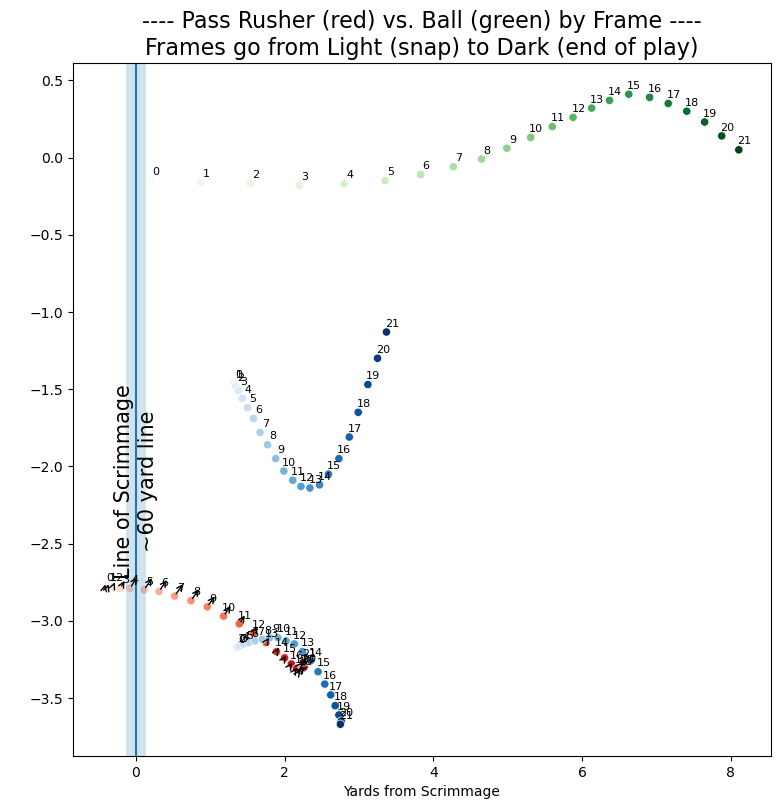

In [69]:
create_single_player_graph(analysis_frames, point_of_scrimmage)

# Test .py functions

In [70]:
import nfl_build_metrics as metrics

In [71]:
game, play, nflId, player_type = metrics.get_random_play_and_player()

In [72]:
# game, play, nflId, player_type = 2021091206,1064,35562,'pass_rusher'

In [73]:
week_num = nfl.get_week_of_game(game)
week_df = acquire.week(week_num)
scout_pass_block = acquire.scout_pass_block()

In [74]:
qb_hold_time, point_of_scrimmage, analysis_frames = nfl.build_play_frames(game, play, week_df, nflId, scout_pass_block, player_type, v_type = 'PvP')

In [75]:
players_df = acquire.players()

In [76]:
analysis_frames = metrics.build_metrics(analysis_frames, point_of_scrimmage, players_df)

In [77]:
analysis_frames

,ball_x,ball_y,ball_next_x,ball_next_y,pass_rusher,pass_rusher_x,pass_rusher_y,pass_rusher_next_x,pass_rusher_next_y,pass_rusher_a,pass_blocker_1,pass_blocker_1_x,pass_blocker_1_y,pass_blocker_1_next_x,pass_blocker_1_next_y,pass_blocker_1_a,pass_blocker_2,pass_blocker_2_x,pass_blocker_2_y,pass_blocker_2_next_x,pass_blocker_2_next_y,pass_blocker_2_a,ball_distance_moved_x,ball_distance_moved_y,pass_rusher_distance_moved_x,pass_rusher_distance_moved_y,pass_blocker_1_distance_moved_x,pass_blocker_1_distance_moved_y,pass_blocker_2_distance_moved_x,pass_blocker_2_distance_moved_y,pass_rusher_to_ball_vector_x,pass_rusher_to_ball_vector_y,ball_to_pass_rusher_vector_x,ball_to_pass_rusher_vector_y,change_in_pass_rusher_to_ball_dist,pass_rusher_to_ball_dist_ratio,pass_rusher_pass_blocker_1_dist,pass_rusher_pass_blocker_2_dist,colinearity,pursuit_factor,escape_factor,pass_rusher_force_to_ball,pursuit_vs_escape,pursuit1,pursuit2,pursuit3,pursuit4
0,1.36,-0.12,1.90,-0.15,43694,-0.87,0.55,-0.84,0.51,1.18,37130,0.41,-0.22,0.41,-0.23,0.17,52480,1.30,1.23,1.30,1.17,0.57,0.54,-0.03,0.03,-0.04,0.00,-0.01,0.00,-0.06,0.0377,-0.0095,0.5172,-0.1246,0.4899,0.8262,1.4938,2.2740,0.6435,0.7777,0.9837,129.41,-0.4931,1.0065,-0.4074,0.071886,-0.911742
1,1.90,-0.15,2.46,-0.20,43694,-0.84,0.51,-0.80,0.46,1.53,37130,0.41,-0.23,0.41,-0.25,0.19,52480,1.30,1.17,1.30,1.12,0.68,0.56,-0.05,0.04,-0.05,0.00,-0.02,0.00,-0.05,0.0485,-0.0104,0.5477,-0.1109,0.5078,0.8473,1.4526,2.2395,0.6917,0.7750,0.9939,167.21,-0.5092,1.0028,-0.4314,0.088225,-0.905683
2,2.46,-0.20,3.00,-0.25,43694,-0.80,0.46,-0.74,0.39,1.63,37130,0.41,-0.25,0.42,-0.26,0.16,52480,1.30,1.12,1.30,1.05,0.63,0.54,-0.05,0.06,-0.07,0.01,-0.01,0.00,-0.07,0.0706,-0.0132,0.5329,-0.0912,0.4682,0.8766,1.4029,2.2013,0.7180,0.7792,0.9970,179.11,-0.4688,1.0013,-0.4110,0.132440,-0.864450
3,3.00,-0.25,3.54,-0.31,43694,-0.74,0.39,-0.68,0.31,1.30,37130,0.42,-0.26,0.44,-0.27,0.12,52480,1.30,1.05,1.29,0.98,0.55,0.54,-0.06,0.06,-0.08,0.02,-0.01,-0.01,-0.07,0.0712,-0.0116,0.5372,-0.0789,0.4709,0.8896,1.3297,2.1441,0.6847,0.7213,0.9994,132.23,-0.4708,0.9998,-0.4188,0.132773,-0.866519
4,3.54,-0.31,4.05,-0.37,43694,-0.68,0.31,-0.62,0.23,0.94,37130,0.44,-0.27,0.46,-0.28,0.27,52480,1.29,0.98,1.28,0.91,0.38,0.51,-0.06,0.06,-0.08,0.02,-0.01,-0.01,-0.07,0.0701,-0.0101,0.5093,-0.0654,0.4431,0.9059,1.2613,2.0808,0.6894,0.7077,0.9999,93.81,-0.4427,0.9991,-0.4010,0.137919,-0.862094
5,4.05,-0.37,4.53,-0.42,43694,-0.62,0.23,-0.55,0.18,0.47,37130,0.46,-0.28,0.50,-0.29,0.32,52480,1.28,0.91,1.27,0.83,0.24,0.48,-0.05,0.07,-0.05,0.04,-0.01,-0.01,-0.08,0.0751,-0.0095,0.4792,-0.0566,0.4069,0.9204,1.1944,2.0180,0.8696,0.8801,0.9999,58.33,-0.4068,0.9998,-0.3744,0.156856,-0.842939
6,4.53,-0.42,4.99,-0.47,43694,-0.55,0.18,-0.48,0.15,0.68,37130,0.50,-0.29,0.54,-0.29,0.36,52480,1.27,0.83,1.25,0.76,0.20,0.46,-0.05,0.07,-0.03,0.04,0.00,-0.02,-0.07,0.0725,-0.0085,0.4598,-0.0521,0.3897,0.9292,1.1504,1.9326,0.9563,0.9588,1.0000,91.94,-0.3897,1.0000,-0.3621,0.157759,-0.842213
7,4.99,-0.47,5.42,-0.51,43694,-0.48,0.15,-0.40,0.13,1.13,37130,0.54,-0.29,0.59,-0.28,0.43,52480,1.25,0.76,1.24,0.71,0.26,0.43,-0.04,0.08,-0.02,0.05,0.01,-0.01,-0.05,0.0812,-0.0091,0.4292,-0.0472,0.3501,0.9402,1.1109,1.8344,0.9884,0.9911,0.9999,157.93,-0.3501,1.0000,-0.3292,0.189203,-0.810686
8,5.42,-0.51,5.81,-0.52,43694,-0.40,0.13,-0.32,0.12,1.23,37130,0.59,-0.28,0.62,-0.26,0.57,52480,1.24,0.71,1.21,0.66,0.59,0.39,-0.01,0.08,-0.01,0.03,0.02,-0.03,-0.05,0.0802,-0.0084,0.3868,-0.0404,0.3082,0.9500,1.0715,1.7395,0.9951,0.9998,0.9969,173.42,-0.3083,1.0003,-0.2929,0.206698,-0.790253
9,5.81,-0.52,6.18,-0.51,43694,-0.32,0.12,-0.23,0.14,1.47,37130,0.62,-0.26,0.67,-0.24,0.52,52480,1.21,0.66,1.21,0.62,0.78,0.37,0.01,0.09,0.02,0.05,0.02,0.00,-0.04,0.0872,-0.0085,0.3652,-0.0370,0.2796,0.9566,1.0139,1.6225,0.9817,0.9507,0.9918,197.08,-0.2795,0.9996,-0.2674,0.236706,-0.755130


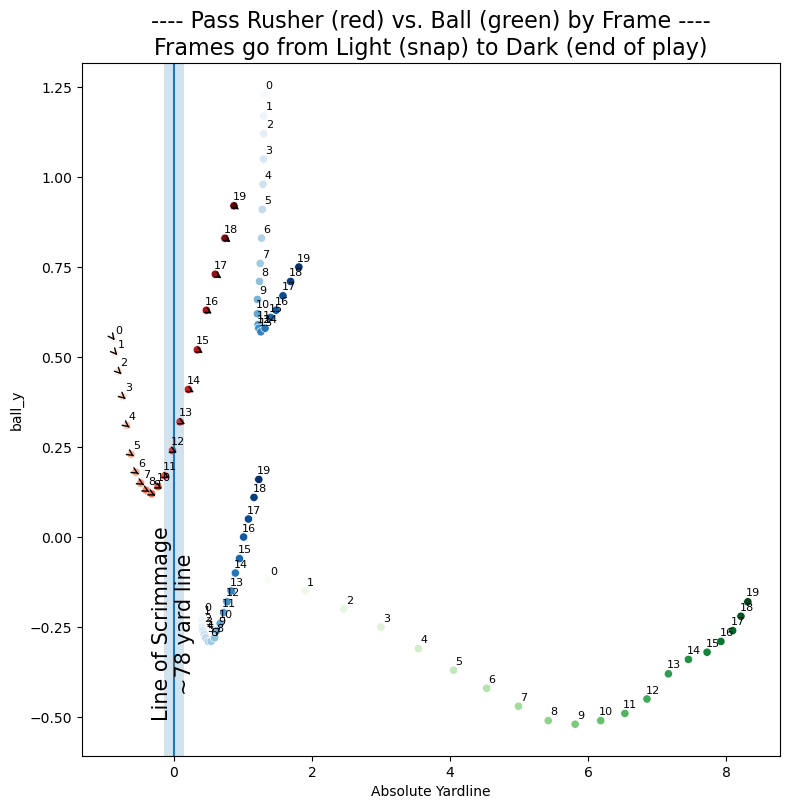

In [78]:
metrics.create_single_player_graph(analysis_frames, point_of_scrimmage)

----